In [1]:
import os
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Literal

from dotenv import load_dotenv
load_dotenv(dotenv_path='D:/GenAI-Practice/AgenticAI-Projects/SmartAssistant/.env')

# Initialize model (replace with your working one, e.g., gemini-2.5-pro)
# llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
#                              temperature=0,
#                              api_key=os.getenv('GOOGLE_API_KEY'))

llm = ChatGroq(
    temperature = 0,
    groq_api_key = os.getenv("groq_api_key"),
    model_name = os.getenv("llama_model_name")
    )

d:\GenAI-Practice\env_RAG\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Classifier Node

In [2]:
from pydantic import BaseModel, Field
from typing import Optional, Literal, List, Any
class ChatbotState(BaseModel):
    """Represents the state of the chatbot flow."""

    query: Optional[str] = Field(
        default=None, 
        description="User's current query"
    )
    query_type: Optional[Literal["llm", "rag", "db"]] = Field(
        default=None, description="Type of query determined by classifier"
    )
    context: Optional[List[str]] = Field(
        default=None, description="Retrieved context for RAG"
    )
    answer: Optional[str] = Field(
        default=None, description="Final generated answer"
    )
    reasoning_trace: Optional[str] = Field(
        default=None, description="Explanation of reasoning"
    )
    memory: Optional[Any] = Field(
        default=None, description="Conversation memory"
    )



In [3]:
# Structured output schema for LLM classification
class QueryClassification(BaseModel):
    query_type: Literal["llm", "rag", "db"] = Field(
        ..., description="Type of query (llm, rag, or db)")
    reasoning: str = Field(..., description="Explanation of why this classification was made")

# Define parser
parser = PydanticOutputParser(pydantic_object=QueryClassification)

# Define prompt
prompt = PromptTemplate(
    template=(
        "You are a query classification assistant. "
        "Given a user question, determine if it should be handled by:\n"
        "- 'llm': for general world knowledge or reasoning questions.\n"
        "- 'rag': for document-based or semantic search questions.\n"
        "- 'db': for database or structured data retrieval queries. Mostly queries will be based on the retrieving the system data.\neg can you tell the system value \n\n"
        "Return a structured JSON matching this schema:\n{format_instructions}\n\n"
        "Question: {query}"
    ),
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

def classify_query_node(state: ChatbotState) -> ChatbotState:
    """Classify query into llm, rag, or db using Gemini and structured output."""
    try:
        input_prompt = prompt.format_prompt(query=state.query)
        response = llm.invoke(input_prompt.to_string())
        parsed = parser.parse(response.content)

        state.query_type = parsed.query_type
        state.reasoning_trace = parsed.reasoning
        return state

    except Exception as e:
        state.query_type = "llm"  # fallback
        state.reasoning_trace = f"Classification failed: {e}"
        return state

Database Node

In [4]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits.sql.base import SQLDatabaseToolkit
from langchain_google_genai import ChatGoogleGenerativeAI

def db_query_node(state: ChatbotState) -> ChatbotState:
    """
    Handles structured data queries via LangChain SQL Agent.
    Executes natural language questions on database and updates the state.
    """
    try:
        # Load database
        db = SQLDatabase.from_uri("sqlite:///D:/GenAI-Practice/AgenticAI-Projects/SmartAssistant/app/data/uploads/system_details.db")

        # Create toolkit for SQL agent
        toolkit = SQLDatabaseToolkit(db=db, llm=llm)

        # Create the SQL agent
        agent_executor = create_sql_agent(
            llm=toolkit.llm,
            toolkit=toolkit,
            verbose=True,
            agent_type="openai-tools",  # works well with Gemini too
        )

        # Run query
        query = state.query
        response = agent_executor.invoke({"input": query})

        # Update chatbot state
        state.answer = response["output"]
        state.reasoning_trace = (
            f"Used SQL Agent on 'sample.db' to execute query derived from user question."
        )
        return state

    except Exception as e:
        state.answer = f"Error during DB query: {e}"
        state.reasoning_trace = "DB Node failed to process query."
        return state


RAG Node

In [5]:
from langchain_community.vectorstores import FAISS
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import RetrievalQA
# from core.embedding_utils import get_huggingface_embedding

import os
from langchain_community.embeddings import HuggingFaceEmbeddings

def get_huggingface_embedding(model_name: str = "sentence-transformers/all-MiniLM-L6-v2"):
    """
    Initialize and return a Hugging Face embedding model.
    Args:
        model_name: Name of the Hugging Face model to use.
    Returns:
        HuggingFaceEmbeddings instance or None if error occurs.
    """
    try:
        print(f"🔹 Initializing Hugging Face Embedding model: {model_name}")
        embeddings = HuggingFaceEmbeddings(model_name=model_name)
        return embeddings
    except Exception as e:
        print(f"⚠️ Error initializing Hugging Face Embedding model: {e}")
        return None

# from chatbot.state import ChatbotState

def rag_node(state: ChatbotState) -> ChatbotState:
    """
    Handles document-based queries using FAISS + LLM.
    Retrieves relevant chunks and generates an answer.
    """
    global llm
    try:
        # Step 1: Load embeddings and FAISS vector store
        embeddings = get_huggingface_embedding()
        vectorstore = FAISS.load_local("D:/GenAI-Practice/AgenticAI-Projects/SmartAssistant/app/data/faiss_index", embeddings, allow_dangerous_deserialization=True)
        retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
        # Step 2: Create LLM (Gemini or fallback)
        llm = llm

        # Step 3: Create Retrieval-QA chain
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=True
        )

        # Step 4: Run the query
        result = qa_chain.invoke({"query": state.query})

        # Step 5: Update state
        state.answer = result["result"]
        state.context = [doc.page_content for doc in result["source_documents"]]
        state.reasoning_trace = (
            "Used FAISS semantic search to find relevant chunks, then used Gemini for synthesis."
        )
        return state

    except Exception as e:
        state.answer = f"RAG failed: {e}"
        state.reasoning_trace = "RAG node failed to process query."
        return state

In [6]:
def rag_node_test(query):
    """
    Handles document-based queries using FAISS + LLM.
    Retrieves relevant chunks and generates an answer.
    """
    global llm
    try:
        # Step 1: Load embeddings and FAISS vector store
        embeddings = get_huggingface_embedding()
        vectorstore = FAISS.load_local("D:/GenAI-Practice/AgenticAI-Projects/SmartAssistant/app/data/faiss_index", embeddings, allow_dangerous_deserialization=True)
        retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
        # Step 2: Create LLM (Gemini or fallback)
        llm = llm

        # Step 3: Create Retrieval-QA chain
        qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=True
        )

        # Step 4: Run the query
        result = qa_chain.invoke({"query": query})
        state = {}
        # Step 5: Update state
        state['answer'] = result["result"]
        state['context'] = [doc.page_content for doc in result["source_documents"]]
        state['reasoning_trace'] = (
            "Used FAISS semantic search to find relevant chunks, then used Gemini for synthesis."
        )
        return state

    except Exception as e:
        state.answer = f"RAG failed: {e}"
        state.reasoning_trace = "RAG node failed to process query."
        return state

In [7]:
# Query = 'what is survivor annunuity percentage for the plan from document?'
Query = 'How many days of notice is needed to withdraw from plan?'
rag_ans = rag_node_test(query = Query)
rag_ans

🔹 Initializing Hugging Face Embedding model: sentence-transformers/all-MiniLM-L6-v2


C:\Users\MSI\AppData\Local\Temp\ipykernel_26080\456007224.py:19: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name)


{'answer': 'According to the text, a Participant who desires to withdraw as a Contributing Participant will need to give notice of withdrawal to the Plan Administrator at least 30 days (or such shorter period as the Plan Administrator will permit in a uniform and nondiscriminatory manner) before the effective date of withdrawal.',
 'context': ['to be effective  . Such amendment will take effect unless within the \n30-day period after such notice is provided, or within such shorter \nperiod as the notice may specify, the Adopting Employer gives the \nPre-approved Document Provider written notice of refusal to consent \nto the amendment  . Such written notice of refusal will have the effect \nof withdrawing the Plan as a pre-approved plan and will cause the \nPlan to be considered an individually designed plan  .\n3  . In addition to the amendment rights described above, the Pre-\napproved Document Provider will have the right to terminate its spon -\nsorship of this Plan by providing no

LLM Node

In [8]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
# from chatbot.state import ChatbotState
# LLM = ChatGoogleGenerativeAI(model="gemini-2.5-pro", api_key=os.getenv('GOOGLE_API_KEY'))

def llm_node(state: ChatbotState) -> ChatbotState:
    """
    Handles open-domain or reasoning queries directly using Gemini.
    """
    global llm
    try:
        llm = llm # ChatGoogleGenerativeAI(model="gemini-2.5-pro", temperature=0.7,  api_key=os.getenv('GOOGLE_API_KEY'))
        response = llm.invoke(state.query)

        state.answer = response.content
        state.reasoning_trace = "Used Gemini directly for general reasoning or world knowledge question."
        return state

    except Exception as e:
        state.answer = f"LLM node failed: {e}"
        state.reasoning_trace = "LLM node could not generate an answer."
        return state

Graph

In [9]:
from langgraph.graph import StateGraph, END

def router(state: ChatbotState) -> str:
    """
    Router node — decides which branch to take based on query_type.
    Returns one of: 'rag', 'db', 'llm'
    """
    if state.query_type == "rag":
        return "rag"
    elif state.query_type == "db":
        return "db"
    else:
        return "llm"


def build_chatbot_graph() -> StateGraph:
    """
    Build the chatbot LangGraph pipeline with classification + routing.
    Compatible with latest LangGraph API.
    """
    graph = StateGraph(ChatbotState)

    # --- Define nodes ---
    graph.add_node("classify", classify_query_node)
    graph.add_node("rag", rag_node)
    graph.add_node("db", db_query_node)
    graph.add_node("llm", llm_node)

    # --- Edges ---
    # First step always goes to classification
    graph.set_entry_point("classify")

    # Conditional routing
    graph.add_conditional_edges(
        "classify",
        router,  # function that returns key: rag / db / llm
        {
            "rag": "rag",
            "db": "db",
            "llm": "llm",
        },
    )

    # --- End edges ---
    graph.add_edge("rag", END)
    graph.add_edge("db", END)
    graph.add_edge("llm", END)

    graph.set_entry_point("classify")

    app = graph.compile()

    return app

# Initialize chatbot graph
chatbot_graph = build_chatbot_graph()

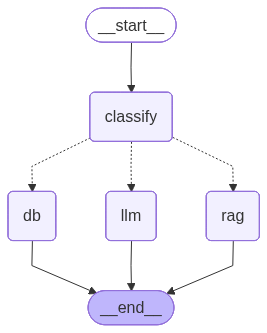

In [10]:
from IPython.display import Image, display

try:
    display(Image(chatbot_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [11]:
initial_state = ChatbotState()
query = 'What is captial of india?'
app_response = chatbot_graph.invoke({'query':query})
app_response

{'query': 'What is captial of india?',
 'query_type': 'llm',
 'answer': 'The capital of India is New Delhi.',
 'reasoning_trace': 'Used Gemini directly for general reasoning or world knowledge question.'}

In [12]:
# Example invocation helper
def run_chatbot(query: str) -> ChatbotState:
    """
    Run the query through the LangGraph pipeline.
    Returns the final ChatbotState with answer, context, reasoning_trace.
    """
    # initial_state = ChatbotState(query=query)
    initial_state = ChatbotState(query=query)
    result_state = chatbot_graph.invoke(initial_state)
    return result_state

In [ ]:
# response = run_chatbot(query = 'what is survivor annuity percentage for the plan from document?')

In [14]:
# run_chatbot(query = 'In the system, what is survivor annunuity percentage for the plan?')

In [15]:
# run_chatbot(query = 'What is capital of US?')

In [16]:
# print(response['answer'])

In [25]:
# D:/GenAI-Practice/AgenticAI-Projects/SmartAssistant/app/data/uploads/system_details.db
db_pth = 'D:/GenAI-Practice/AgenticAI-Projects/SmartAssistant/smartapp/data/db_uploads/'
files = [file for file in os.listdir(db_pth) if file.endswith('.db')]
os.path.join(db_pth,files[0])

'D:/GenAI-Practice/AgenticAI-Projects/SmartAssistant/smartapp/data/db_uploads/system_details.db'

In [ ]:
what is survivor annuity percentage for the plan from document?

form the system, what is the value for the provision 'Survivor annuity percentage'?



False
